<a href="https://colab.research.google.com/github/deepkick/kagglebook/blob/master/ch01/PredictFutureSales_A_beginner_guide_for_sale_data_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A beginner guide for sale data prediction
https://www.kaggle.com/minhtriet/a-beginner-guide-for-sale-data-prediction  

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

%matplotlib inline

train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')
items = pd.read_csv('../input/items.csv')
item_cats = pd.read_csv('../input/item_categories.csv')
shops = pd.read_csv('../input/shops.csv')

In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59.0,22154.0,999.00,1.0
1,03.01.2013,0,25.0,2552.0,899.00,1.0
2,05.01.2013,0,25.0,2552.0,899.00,-1.0
3,06.01.2013,0,25.0,2554.0,1709.05,1.0
4,15.01.2013,0,25.0,2555.0,1099.00,1.0
...,...,...,...,...,...,...
2736372,21.07.2015,30,42.0,16167.0,799.00,1.0
2736373,24.07.2015,30,42.0,16167.0,799.00,1.0
2736374,12.07.2015,30,42.0,16169.0,299.00,1.0
2736375,09.07.2015,30,42.0,16170.0,1999.00,1.0


In [12]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [13]:

test_shops = test.shop_id.unique()
train = train[train.shop_id.isin(test_shops)]
test_items = test.item_id.unique()
train = train[train.item_id.isin(test_items)]


In [14]:
MAX_BLOCK_NUM = train.date_block_num.max()
MAX_ITEM = len(test_items)
MAX_CAT = len(item_cats)
MAX_YEAR = 3
MAX_MONTH = 4 # 7 8 9 10
MAX_SHOP = len(test_shops)

In [15]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59.0,22154.0,999.0,1.0
10,03.01.2013,0,25.0,2574.0,399.0,2.0
11,05.01.2013,0,25.0,2574.0,399.0,1.0
12,07.01.2013,0,25.0,2574.0,399.0,1.0
13,08.01.2013,0,25.0,2574.0,399.0,2.0
...,...,...,...,...,...,...
2736371,20.07.2015,30,42.0,16156.0,1299.0,-1.0
2736372,21.07.2015,30,42.0,16167.0,799.0,1.0
2736373,24.07.2015,30,42.0,16167.0,799.0,1.0
2736374,12.07.2015,30,42.0,16169.0,299.0,1.0


In [16]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


## Data Exploration

Next, we would like to gain some insights about the data. I will attack from two angles, shop and item categories.

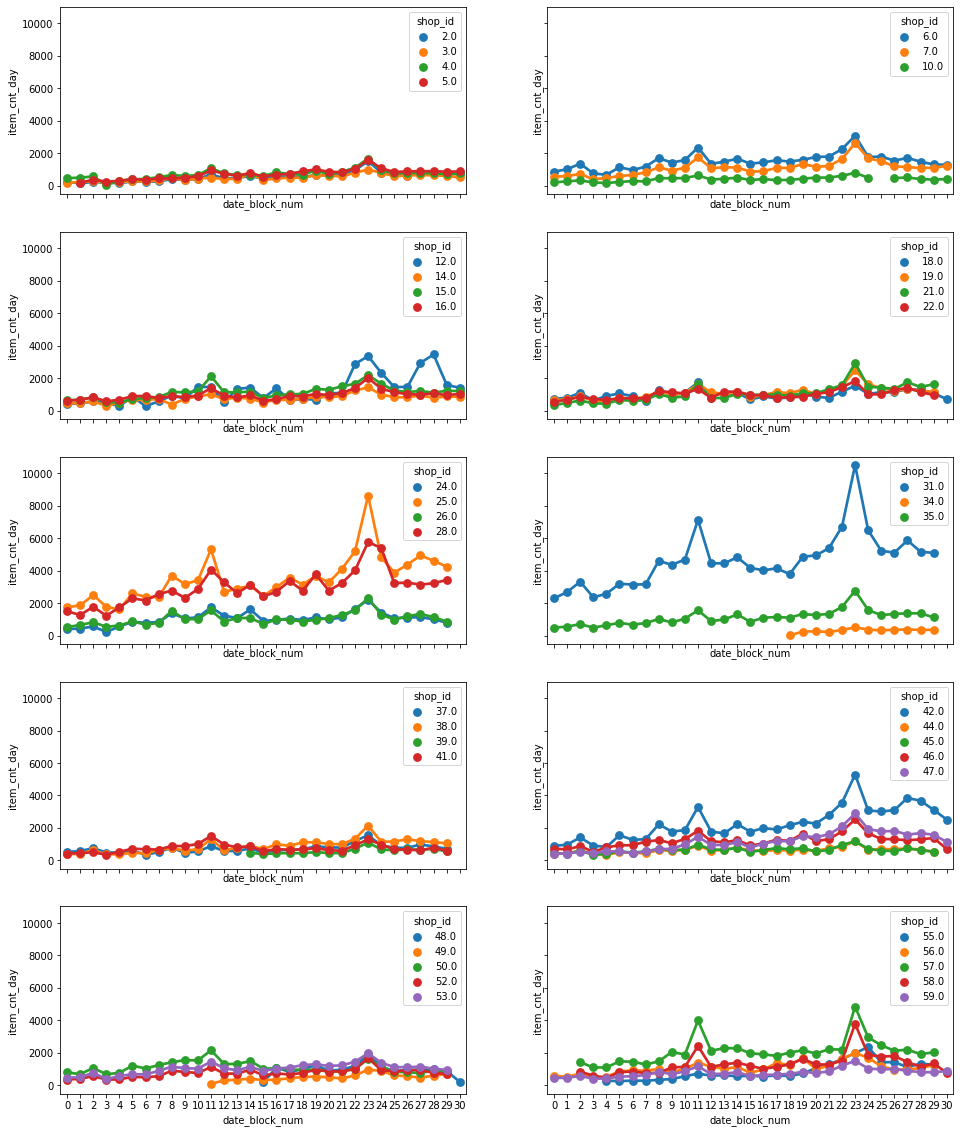

In [17]:
grouped = pd.DataFrame(train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(grouped.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id', data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

明らかに、年末にショップショップのピークがありますが、これはおそらくホリデーシーズンのためです。したがって、このパターンをネットワークが拾えるように、月と年を追加することは有益でしょう。各アイテムのセールの様子がわかるといいですね。しかし、アイテム数を考えると、各アイテムのカテゴリーがどうなっているのかを見た方が有益だと思います。

In [18]:
# add categories
train = train.set_index('item_id').join(items.set_index('item_id')).drop('item_name', axis=1).reset_index()

In [19]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))

In [20]:
train

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day,item_category_id,month,year
0,30.0,28.02.2013,1,50.0,399.0,1.0,40,02,2013
1,30.0,26.02.2013,1,50.0,399.0,1.0,40,02,2013
2,30.0,12.02.2013,1,50.0,399.0,1.0,40,02,2013
3,30.0,14.02.2013,1,50.0,399.0,2.0,40,02,2013
4,30.0,15.02.2013,1,50.0,399.0,3.0,40,02,2013
...,...,...,...,...,...,...,...,...,...
1047103,22167.0,07.07.2015,30,12.0,299.0,1.0,49,07,2015
1047104,22167.0,21.07.2015,30,12.0,299.0,1.0,49,07,2015
1047105,22167.0,24.07.2015,30,12.0,299.0,1.0,49,07,2015
1047106,22167.0,15.07.2015,30,47.0,299.0,1.0,49,07,2015


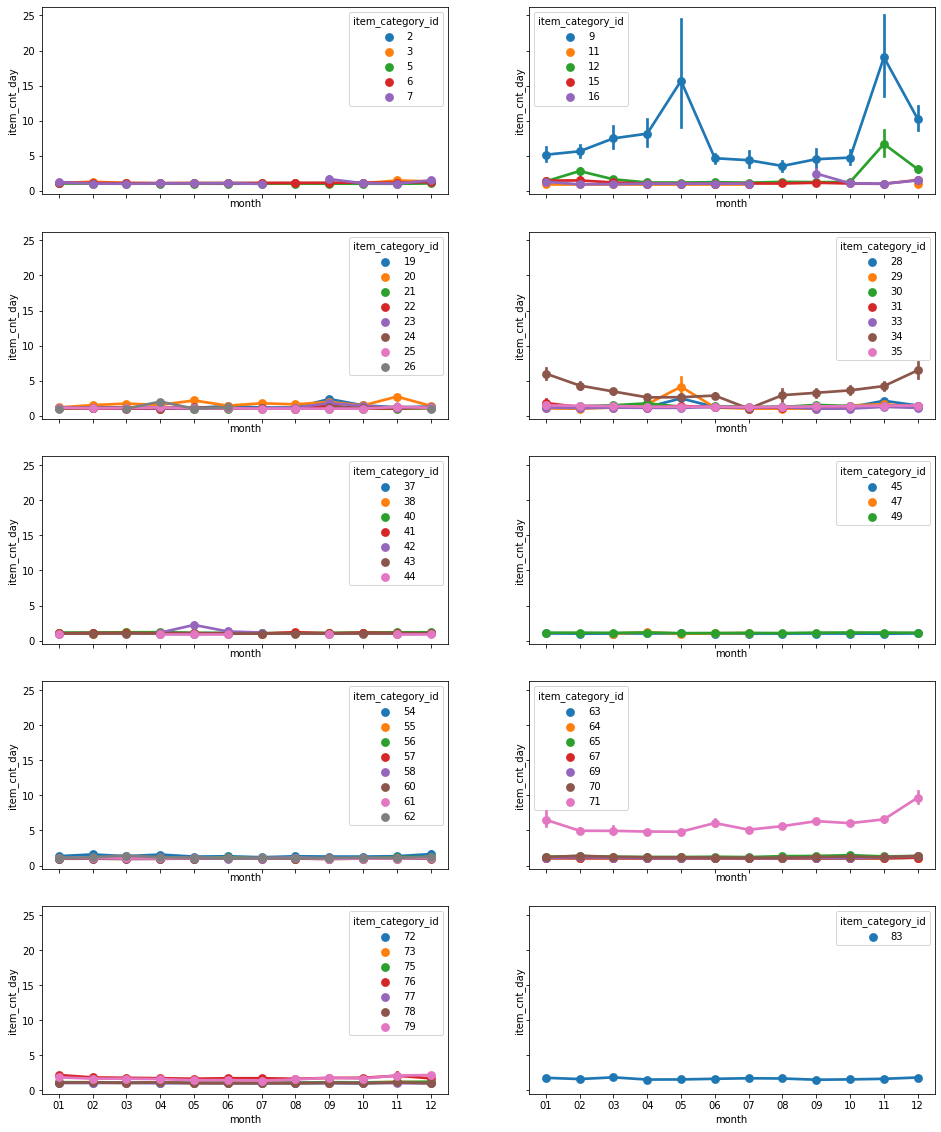

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

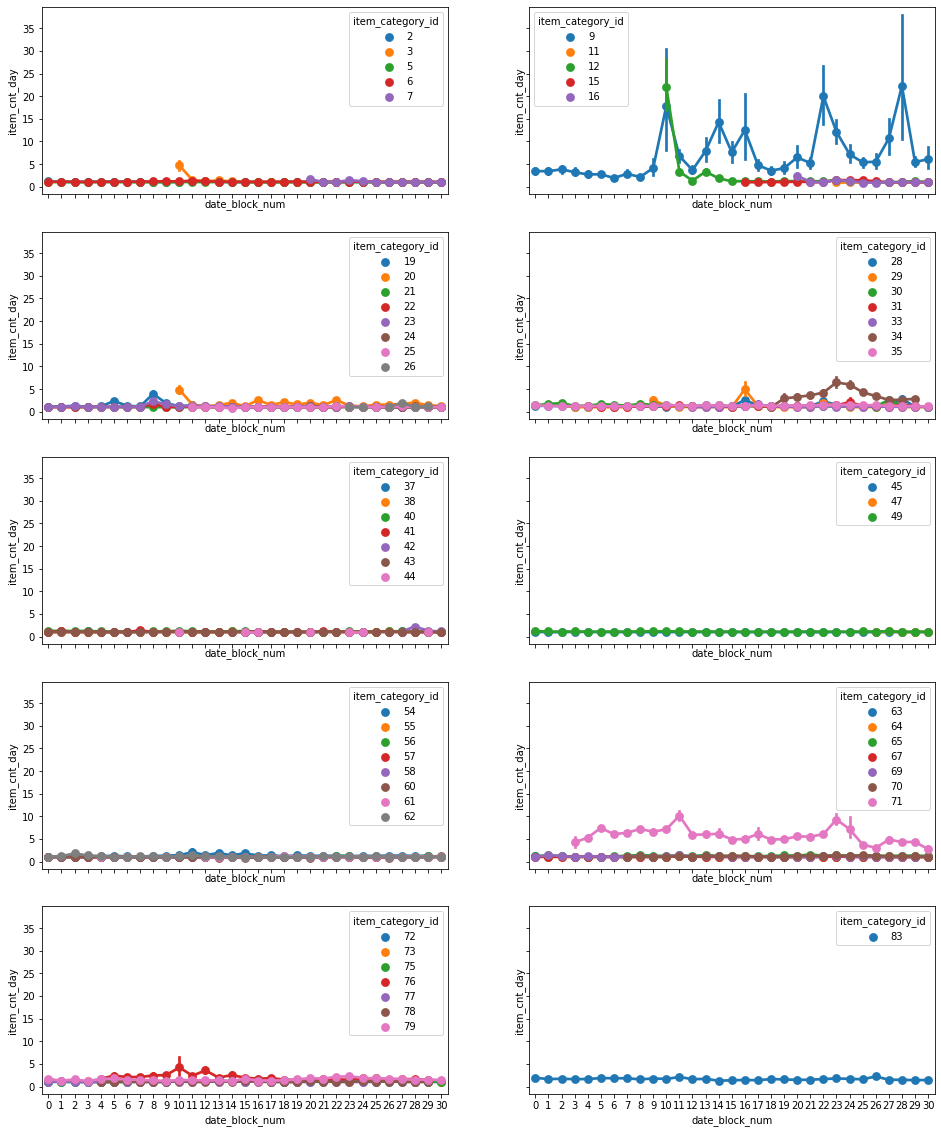

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(train.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='item_category_id', 
                      data=train[np.logical_and(count*id_per_graph <= train['item_category_id'], train['item_category_id'] < (count+1)*id_per_graph)], 
                      ax=axes[i][j])
        count += 1

In [23]:
train = train.drop('date', axis=1)
train = train.drop('item_category_id', axis=1)
train = train.groupby(['shop_id', 'item_id', 'date_block_num', 'month', 'year']).sum()
train = train.sort_index()

In [24]:
train

item_price  item_cnt_day
shop_id item_id date_block_num month year                          
2.0     30.0    2              03    2013       359.0           1.0
                5              06    2013       399.0           1.0
                15             04    2014       169.0           1.0
                16             05    2014       169.0           1.0
        31.0    1              02    2013      2796.0           4.0
...                                               ...           ...
59.0    22164.0 27             04    2015      1398.0           2.0
                30             07    2015       699.0           1.0
        22167.0 9              10    2013       299.0           1.0
                11             12    2013       598.0           2.0
                17             06    2014       299.0           1.0

[498877 rows x 2 columns]

## Training  

In gradient based learning method, it is common to normalize the numerical variable to speed up the training

In [28]:
scaler = StandardScaler()
cnt_scaler = StandardScaler()

scaler.fit(train.item_price.values.reshape(-1, 1))
cnt_scaler.fit(train.item_cnt_day.values.reshape(-1, 1))

train.item_price = scaler.transform(train.item_price.values.reshape(-1, 1))
train.item_cnt_day = cnt_scaler.transform(train.item_cnt_day.values.reshape(-1, 1))

訓練セット全体をエンコードしてネットワークに送り込もうとするのは自然なことです。しかし、このアプローチには2つの欠点がある。

* それは、2013年1月からの販売データや近い時期の販売データが2015年11月の販売に影響を与える可能性が低いことです。
* メモリ要件は、Kaggleが提供する限界を超えています。

我々は代わりに2013年と2014年の7月、8月、9月、10月、11月のシーケンスを学習します。

## Missing data  

上記の時間帯に全てのアイテムが販売されているわけではありませんので、item_cnt_dayを0にしてレコードを追加します。 価格はちょっと厄介です。下のコードを見ていただければわかるように、商品の価格はお店や時間帯によって異なります。空の値は過去のレコードの中で一番近いもので埋めていきます。

In [29]:
train.reset_index().groupby(['item_id', 'date_block_num', 'shop_id']).mean()

item_price  item_cnt_day
item_id date_block_num shop_id                          
30.0    1              3.0       -0.073210      0.102668
                       4.0        0.034768      0.361302
                       5.0       -0.073210      0.188880
                       6.0        0.293438      2.171738
                       7.0        0.137334      0.619936
...                                    ...           ...
22167.0 30             3.0       -0.248709     -0.155965
                       6.0       -0.248709     -0.155965
                       12.0      -0.167793      0.016457
                       16.0      -0.248709     -0.155965
                       47.0      -0.208251     -0.069754

[498877 rows x 2 columns]

グループ化しやすいように、グループ化の順番を少し変えてみます。

In [30]:
price = train.reset_index().set_index(['item_id', 'shop_id', 'date_block_num'])
price = price.sort_index()

In [31]:
price

month  year  item_price  item_cnt_day
item_id shop_id date_block_num                                      
30.0    2.0     2                 03  2013   -0.240590     -0.155965
                5                 06  2013   -0.235177     -0.155965
                15                04  2014   -0.266299     -0.155965
                16                05  2014   -0.266299     -0.155965
        3.0     1                 02  2013   -0.073210      0.102668
...                              ...   ...         ...           ...
22167.0 58.0    14                03  2014   -0.248709     -0.155965
                20                09  2014   -0.248709     -0.155965
        59.0    9                 10  2013   -0.248709     -0.155965
                11                12  2013   -0.208251     -0.069754
                17                06  2014   -0.248709     -0.155965

[498877 rows x 4 columns]

そして、ヘルパー関数を定義します。

In [32]:
def convert(date_block):
    date = datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return (date.month, date.year)

def closest_date_block(current_day, item_id, shop_id):
    """Find the block_date which is closest to the current_day, given item_id and shop_id. Returns index integer"""
    if (item_id, shop_id) in price.index:
        search_lst = np.array(price.loc[(item_id, shop_id)].index)        
        return search_lst[np.abs(current_day - search_lst).argmin()]
    return -1
                
def closest_price(current_day, item_id, shop_id):
    closest_date = closest_date_block(current_day, item_id, shop_id)
    if closest_date != -1:
        return price.loc[( item_id, shop_id, closest_date )]['item_price']
    return np.nan

def closest_price_lambda(x):
    return closest_price(34, x.item_id, x.shop_id)

In [33]:
assert closest_date_block(18, 30, 5) == 18

In [34]:
# Some simple math to know what date_block_num to start learning
print(convert(6))
print(convert(18))
print(convert(30))

(7, 2013)
(7, 2014)
(7, 2015)


どのようなブロックで鍛えるべきか、簡単な計算をしてみます。

In [36]:
maxlen = 4 # 4 months
step = 1
# 0: train, 1: val, 2:test
sentences = [[],[],[]]
next_chars = [[], []]
BLOCKS = [6, 18, 30]

for s in test_shops:
    shop_items = list(train.loc[s].index.get_level_values(0).unique())
    for it in shop_items:        
        for i_index, i in enumerate(BLOCKS):
            sentence = []
            closest_pc = closest_price(i, it, s)            
            for j in range(maxlen+1):
                if j < maxlen:
                    if (s, it, i+j) in train.index:
                        r = train.loc[(s, it, i + j)].to_dict(orient='list')                    
                        closest_pc = r['item_price'][0]
                        item_cnt_day = r['item_cnt_day'][0]
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': item_cnt_day, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    else:
                        month, year = convert(i+j)                    
                        row = {'shop_id': s, 'date_block_num': i+j, 'item_cnt_day': 0, 
                               'month': month, 'item_id': it, 'item_price': closest_pc, 'year': year}
                    sentence.append(row)
                elif i_index < 2:   # not in test set
                    next_chars[i_index].append(row)
            sentences[i_index].append(sentence)

KeyboardInterrupt: ignored

In [37]:
x_train_o = np.array(sentences[0])
x_val_o = np.array(sentences[1])
x_test_o = np.array(sentences[2])
y_train = np.array([x['item_cnt_day'] for x in next_chars[0]])
y_val = np.array([x['item_cnt_day'] for x in next_chars[1]])

In [38]:
length = MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1 + 1

次に、カテゴリカルな値をワンショットエンコーディングのバージョンに変換します。

In [39]:
from sklearn import preprocessing

shop_le = preprocessing.LabelEncoder()
shop_le.fit(test_shops)
shop_dm = dict(zip(test_shops, shop_le.transform(test_shops)))

item_le = preprocessing.LabelEncoder()
item_le.fit(test_items)
item_dm = dict(zip(test_items, item_le.transform(test_items)))

month_le = preprocessing.LabelEncoder()
month_le.fit(range(7,11))
month_dm = dict(zip(range(7,11), month_le.transform(range(7,11))))

#cat_le = preprocessing.LabelEncoder()
#cat_le.fit(item_cats.item_category_id)
#cat_dm = dict(zip(item_cats.item_category_id.unique(), cat_le.transform(item_cats.item_category_id.unique())))

In [40]:
def vectorize(inp):
    print('Vectorization...')   
    x = np.zeros((len(inp), maxlen, length), dtype=np.float32)
    for i, sentence in enumerate(inp):
        for t, char in enumerate(sentence):            
            x[i][t][ shop_dm[char['shop_id']] ] = 1        
            x[i][t][ MAX_SHOP + item_dm[char['item_id']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + month_dm[char['month']] ] = 1
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 ] = char['item_price']
            x[i][t][ MAX_SHOP + MAX_ITEM + MAX_MONTH + 1 + 1] = char['item_cnt_day']    
    return x

In [41]:
x_train = vectorize(x_train_o)
x_val = vectorize(x_val_o)
x_test = vectorize(x_test_o)

Vectorization...
Vectorization...
Vectorization...


In [42]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(32, input_shape=(maxlen, length)))
model.add(Dense(1, activation='relu'))

optimizer = RMSprop(lr=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)

model.fit(x_train, y_train, batch_size=128, epochs=13)

Build model...
Epoch 1/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 2/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0120
Epoch 3/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0082
Epoch 4/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0033
Epoch 5/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 6/13
12/12 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 7/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 8/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 9/13
12/12 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 10/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0025
Epoch 11/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 12/13
12/12 [==============================] - 0s 8ms/step - loss: 0.0027
Epoch 13/13
12/12 [===============

以下はモデルの評価コードです。カーネルの速度のためにコメントしましたが、セルの最後に結果が残っています。

In [43]:
#import math
#from sklearn.metrics import mean_squared_error

# make predictions
#predict_train = model.predict(x_train)
#predict_val = model.predict(x_val)
# invert predictions
#predict_train = cnt_scaler.inverse_transform(predict_train)
#y_train = cnt_scaler.inverse_transform(y_train)
#predict_val = cnt_scaler.inverse_transform(predict_val)
#y_val = cnt_scaler.inverse_transform(y_val)
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
#print('Train Score: %.2f RMSE' % (trainScore))
#valScore = math.sqrt(mean_squared_error(predict_val, y_val))
#print('Test Score: %.2f RMSE' % (valScore))
#For 1 epoch
#Train Score: 3.85 RMSE
#Test Score: 4.29 RMSE

## Inference  
With everything prepared, let's moved to the inference part

In [44]:
predict_test = model.predict(x_test)
predict_test = cnt_scaler.inverse_transform(predict_test)

In [45]:
test = test.set_index(['shop_id', 'item_id'])
test['item_cnt_month'] = 0

In [46]:
for index, sentence in enumerate(x_test_o):
    (shop_id, item_id) = (sentence[0]['shop_id'], sentence[0]['item_id'])
    test.loc[(shop_id, item_id)]['item_cnt_month'] = predict_test[index]

In [47]:
test = test.reset_index().drop(['shop_id', 'item_id'], axis=1)
test.to_csv('submission.csv', index=False)